## Agent-Lab: Azure Entra ID Voice Memos Agent

### Setup

1. Login using az-cli:

```bash
az login --use-device-code
```

2. Create [App Registration](https://portal.azure.com/#view/Microsoft_AAD_RegisteredApps/ApplicationsListBlade) with the name `agent-lab`

3. Adjust [App Registration API Permissions](https://github.com/bsantanna/agent-lab/blob/main/doc/azure_entra_id_voice_memos_agent/app_registration_permissions.png)

4. Obtain AZURE_CLIENT_ID:

```bash
export AZURE_CLIENT_ID=$(az ad app list --display-name agent-lab --query "[0].appId" -o tsv)
```

5. Obtain AZURE_CLIENT_SECRET:

```bash
export AZURE_CLIENT_SECRET=$(az ad app credential reset --id ${AZURE_CLIENT_ID} --query "password" -o tsv)
```

6. Obtain AZURE_TENANT_ID:

```bash
export AZURE_TENANT_ID=$(az account show --query "tenantId" -o tsv)
```

7. Create a User

```bash
az ad user create \
   --display-name "Aline Real Madre" \
   --password "???" \
   --user-principal-name "a.real.madre@mailbsantanna.onmicrosoft.com" \
   --mail-nickname "a.real.madre"
```

8. Verify user:  [entra.microsoft.com](https://entra.microsoft.com/#view/Microsoft_AAD_UsersAndTenants/UserManagementMenuBlade/~/AllUsers/menuId/)





In [1]:
%%capture
import json
import os
import nest_asyncio
from IPython.display import Markdown, display, Audio
from dotenv import load_dotenv
from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

os.chdir("..")
load_dotenv()
nest_asyncio.apply()

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

---
### Upload Audio Attachment

In [2]:
# create attachment
file_path = "tests/integration/voice_memos_01_pt_BR.mp3"
attachment_id = experiment_utils.create_attachment(
    file_path=file_path, content_type="audio/mp3"
)
display(Audio(file_path))

---
### OpenAI Voice Assistant

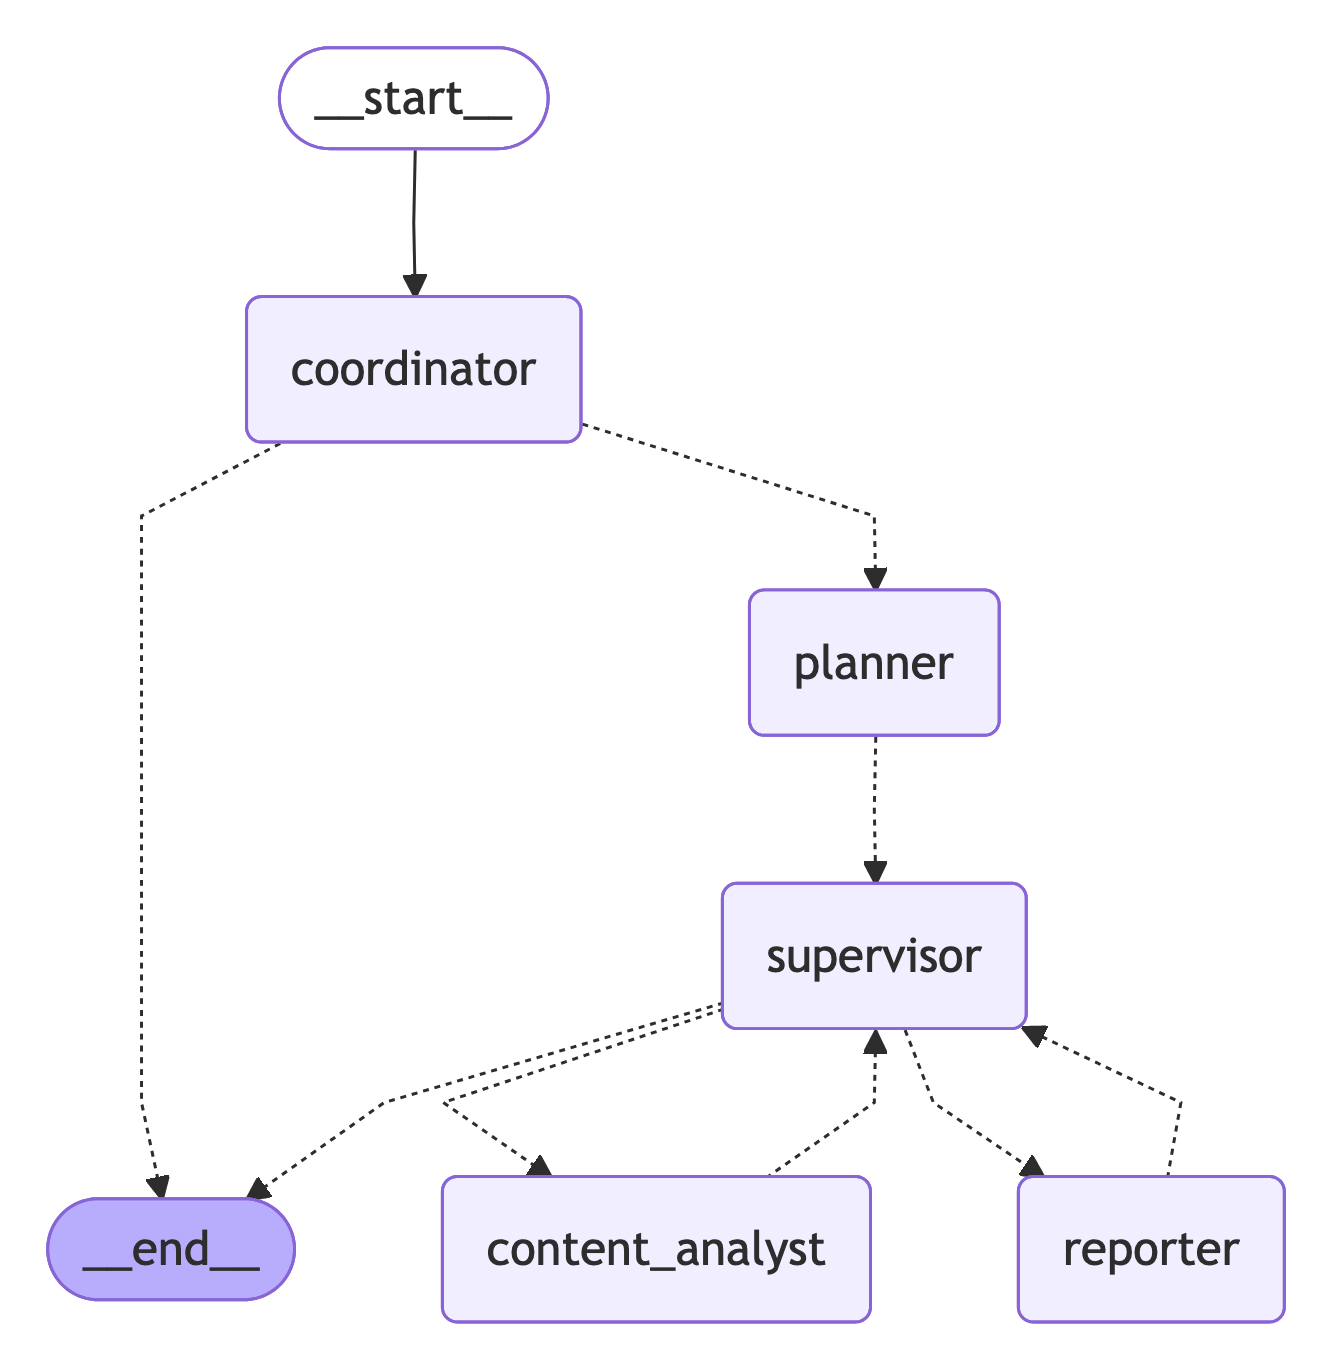

In [3]:
# Create Workflow
openai_agent = experiment_utils.create_openai_agent(
    agent_type="azure_entra_id_voice_memos", llm_tag="gpt-5-nano", api_key=os.getenv("OPENAI_API_KEY")
)
openai_voice_assistant = container.azure_entra_id_voice_memos_agent()
openai_workflow_builder = openai_voice_assistant.get_workflow_builder(openai_agent["id"])
openai_workflow = openai_workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(openai_workflow)

In [4]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content=(
        "Analyse the given audio."
    ),
    agent_id=openai_agent["id"],
    attachment_id=attachment_id,
)

inputs = openai_voice_assistant.get_input_params(message, schema="public")
config = openai_voice_assistant.get_config(openai_agent["id"])
result = openai_workflow.invoke(inputs, config)
ai_message_content, workflow_state = openai_voice_assistant.format_response(result)

In [5]:
display(
    Markdown(
        f"**Execution Plan:**\n```json\n{json.dumps(workflow_state.get("execution_plan"), indent=2)}\n```"
    )
)

**Execution Plan:**
```json
{
  "thought": "The user describes a meeting at 11 AM with Aline from marketing about Project Agente X. The project is delayed and needs to speed up development. The sales team is concerned about the delivery timeline. An update needs to be presented at the next meeting scheduled for next week.",
  "title": "Plan to analyse and report on Project 'Agente X' development status",
  "steps": [
    {
      "agent_name": "content_analyst",
      "title": "Extract and summarize key inputs from audio; create Markdown findings",
      "description": "Interpret the provided audio transcription and produce a Markdown report that captures: meeting time (11 AM), participant (Aline from marketing), project name (Agente X), current status (delay), required action (speed up development), sales concerns about the delivery timeline, and the next meeting update scheduled for next week. Output: a Markdown document with a Findings section including bullet points."
    },
    {
      "agent_name": "reporter",
      "title": "Generate final JSON report for user",
      "description": "Using the Markdown findings from Step 1, generate a final JSON document that summarizes the meeting inputs and status: meeting_time, participants, project_name, status, urgency, concerns, next_update_date, and recommended_actions. Output: a JSON document suitable for sharing with stakeholders."
    }
  ]
}
```

In [6]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

**Main Topic**  
Status update on Project "Agente X" development; discussion of delays and need to accelerate progress; next update planned for next week.

**Discussed points**  
- Meeting was at 11 AM; participant: Aline Real Madre from the marketing team.  
- Project discussed: Agente X.  
- Current status: development is delayed; there is a need to speed up progress.  
- Sales team concerns: delivery timeline is a concern.  
- Next: an update on the project status should be presented at the next meeting, scheduled for next week.

**Decisions taken**  
- Agreed to present an updated status on Project Agente X at the next meeting (next week).  
- Acknowledgement that development pace must improve (no detailed plan approved in this excerpt).

**Next steps**  
- Prepare and approve an updated project status for Agente X to be shared at the next meeting.  
- Coordinate to gather updated timelines, risks, and potential acceleration measures.  
- Confirm attendees and agenda for the next week’s update.

**Action points**  
- Aline Real Madre (Marketing) to coordinate with the project team (and other stakeholders) to identify causes of delay and draft an accelerated delivery plan; prepare a concise update for the next meeting.  
- Project/Engineering team to provide a revised delivery timeline and risk assessment for Agente X.  
- Sales team to document and communicate specific timeline concerns to inform the update.

**Named entities**  
- Aline Real Madre — Organization: Santanna (domain inferred from email), Role: Manager A, Department: Marketing (based on transcription indicating “marketing team”). Email: a.real.madre@mailbsantanna.onmicrosoft.com

Notes:
- All details are based on the transcription provided. If you have more names or need further enrichment (e.g., direct emails for other participants or exact org units), I can look them up and add them.